# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from scipy.stats import invgamma, chi2, t
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import mne 
from mne.preprocessing import ICA
import warnings
warnings.filterwarnings("ignore")
np.random.seed(800)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Antisparse_Copula'

# Source Generation and Mixing Scenario

31.296326243806
The following is the mixture matrix A


<IPython.core.display.Math object>

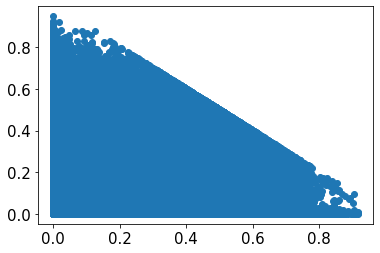

In [3]:
NumberofSources = 5
NumberofMixtures = 10
N = 5*1e5
S = 2*np.random.uniform(size = (NumberofSources,int(N)))-1
S = ProjectRowstoL1NormBall(S.T).T
S = S*(S>=0)

INPUT_STD = 0.5
A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S
for M in range(A.shape[0]):
    stdx = np.std(X[M,:])
    A[M,:] = A[M,:]/stdx * INPUT_STD

SNR=30
# A = np.abs(A)
Xn = A @ S
Noisecomp=np.random.randn(A.shape[0],S.shape[1])*np.power(10,-SNR/20)*INPUT_STD
X=Xn+Noisecomp

print(20*np.log10(np.std(Xn)/np.std(Noisecomp)))
print('The following is the mixture matrix A')
display_matrix(A)

plt.scatter(S[0,:], S[2,:])
plt.show()

# Visualize Generated Sources and Mixtures

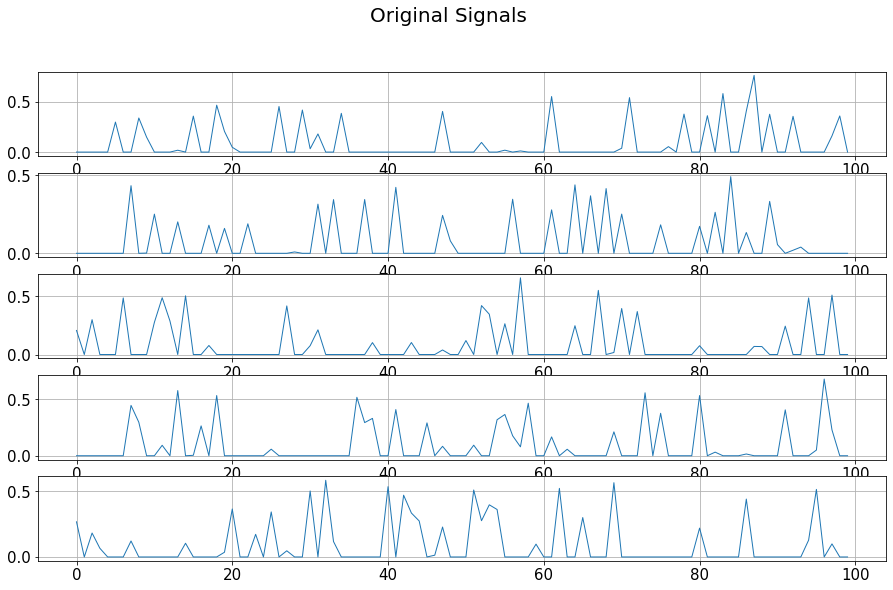

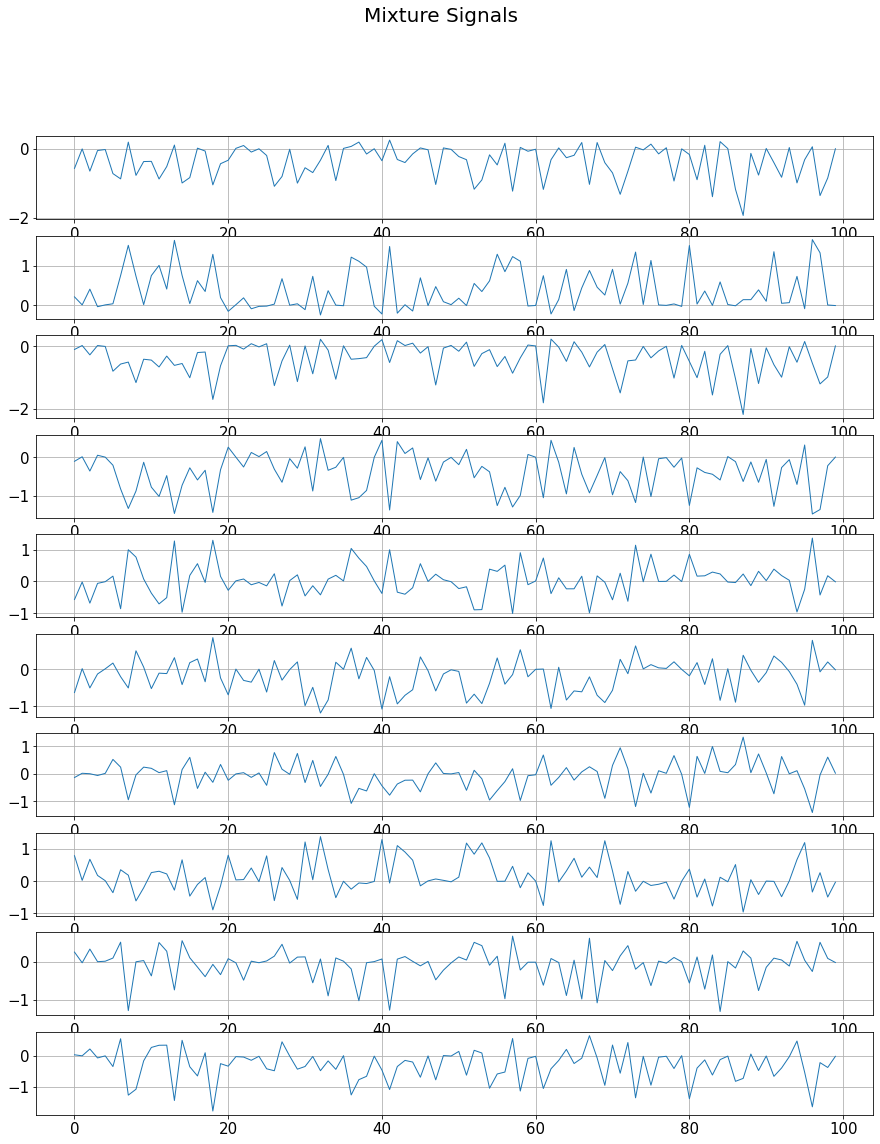

In [4]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [5]:
MUS = 0.25
OUTPUT_COMP_TOL = 1e-5
MAX_OUT_ITERATIONS= 3000
LayerGains = [8,1]
LayerMinimumGains = [1e-6,1]
LayerMaximumGains = [1e6,1.001]
WScalings = [0.0033,0.0033]
GamScalings = [0.02,0.02]
zeta = 1e-4
beta = 0.5
muD = [20, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]

# Run WSM Algorithm on Mixture Signals

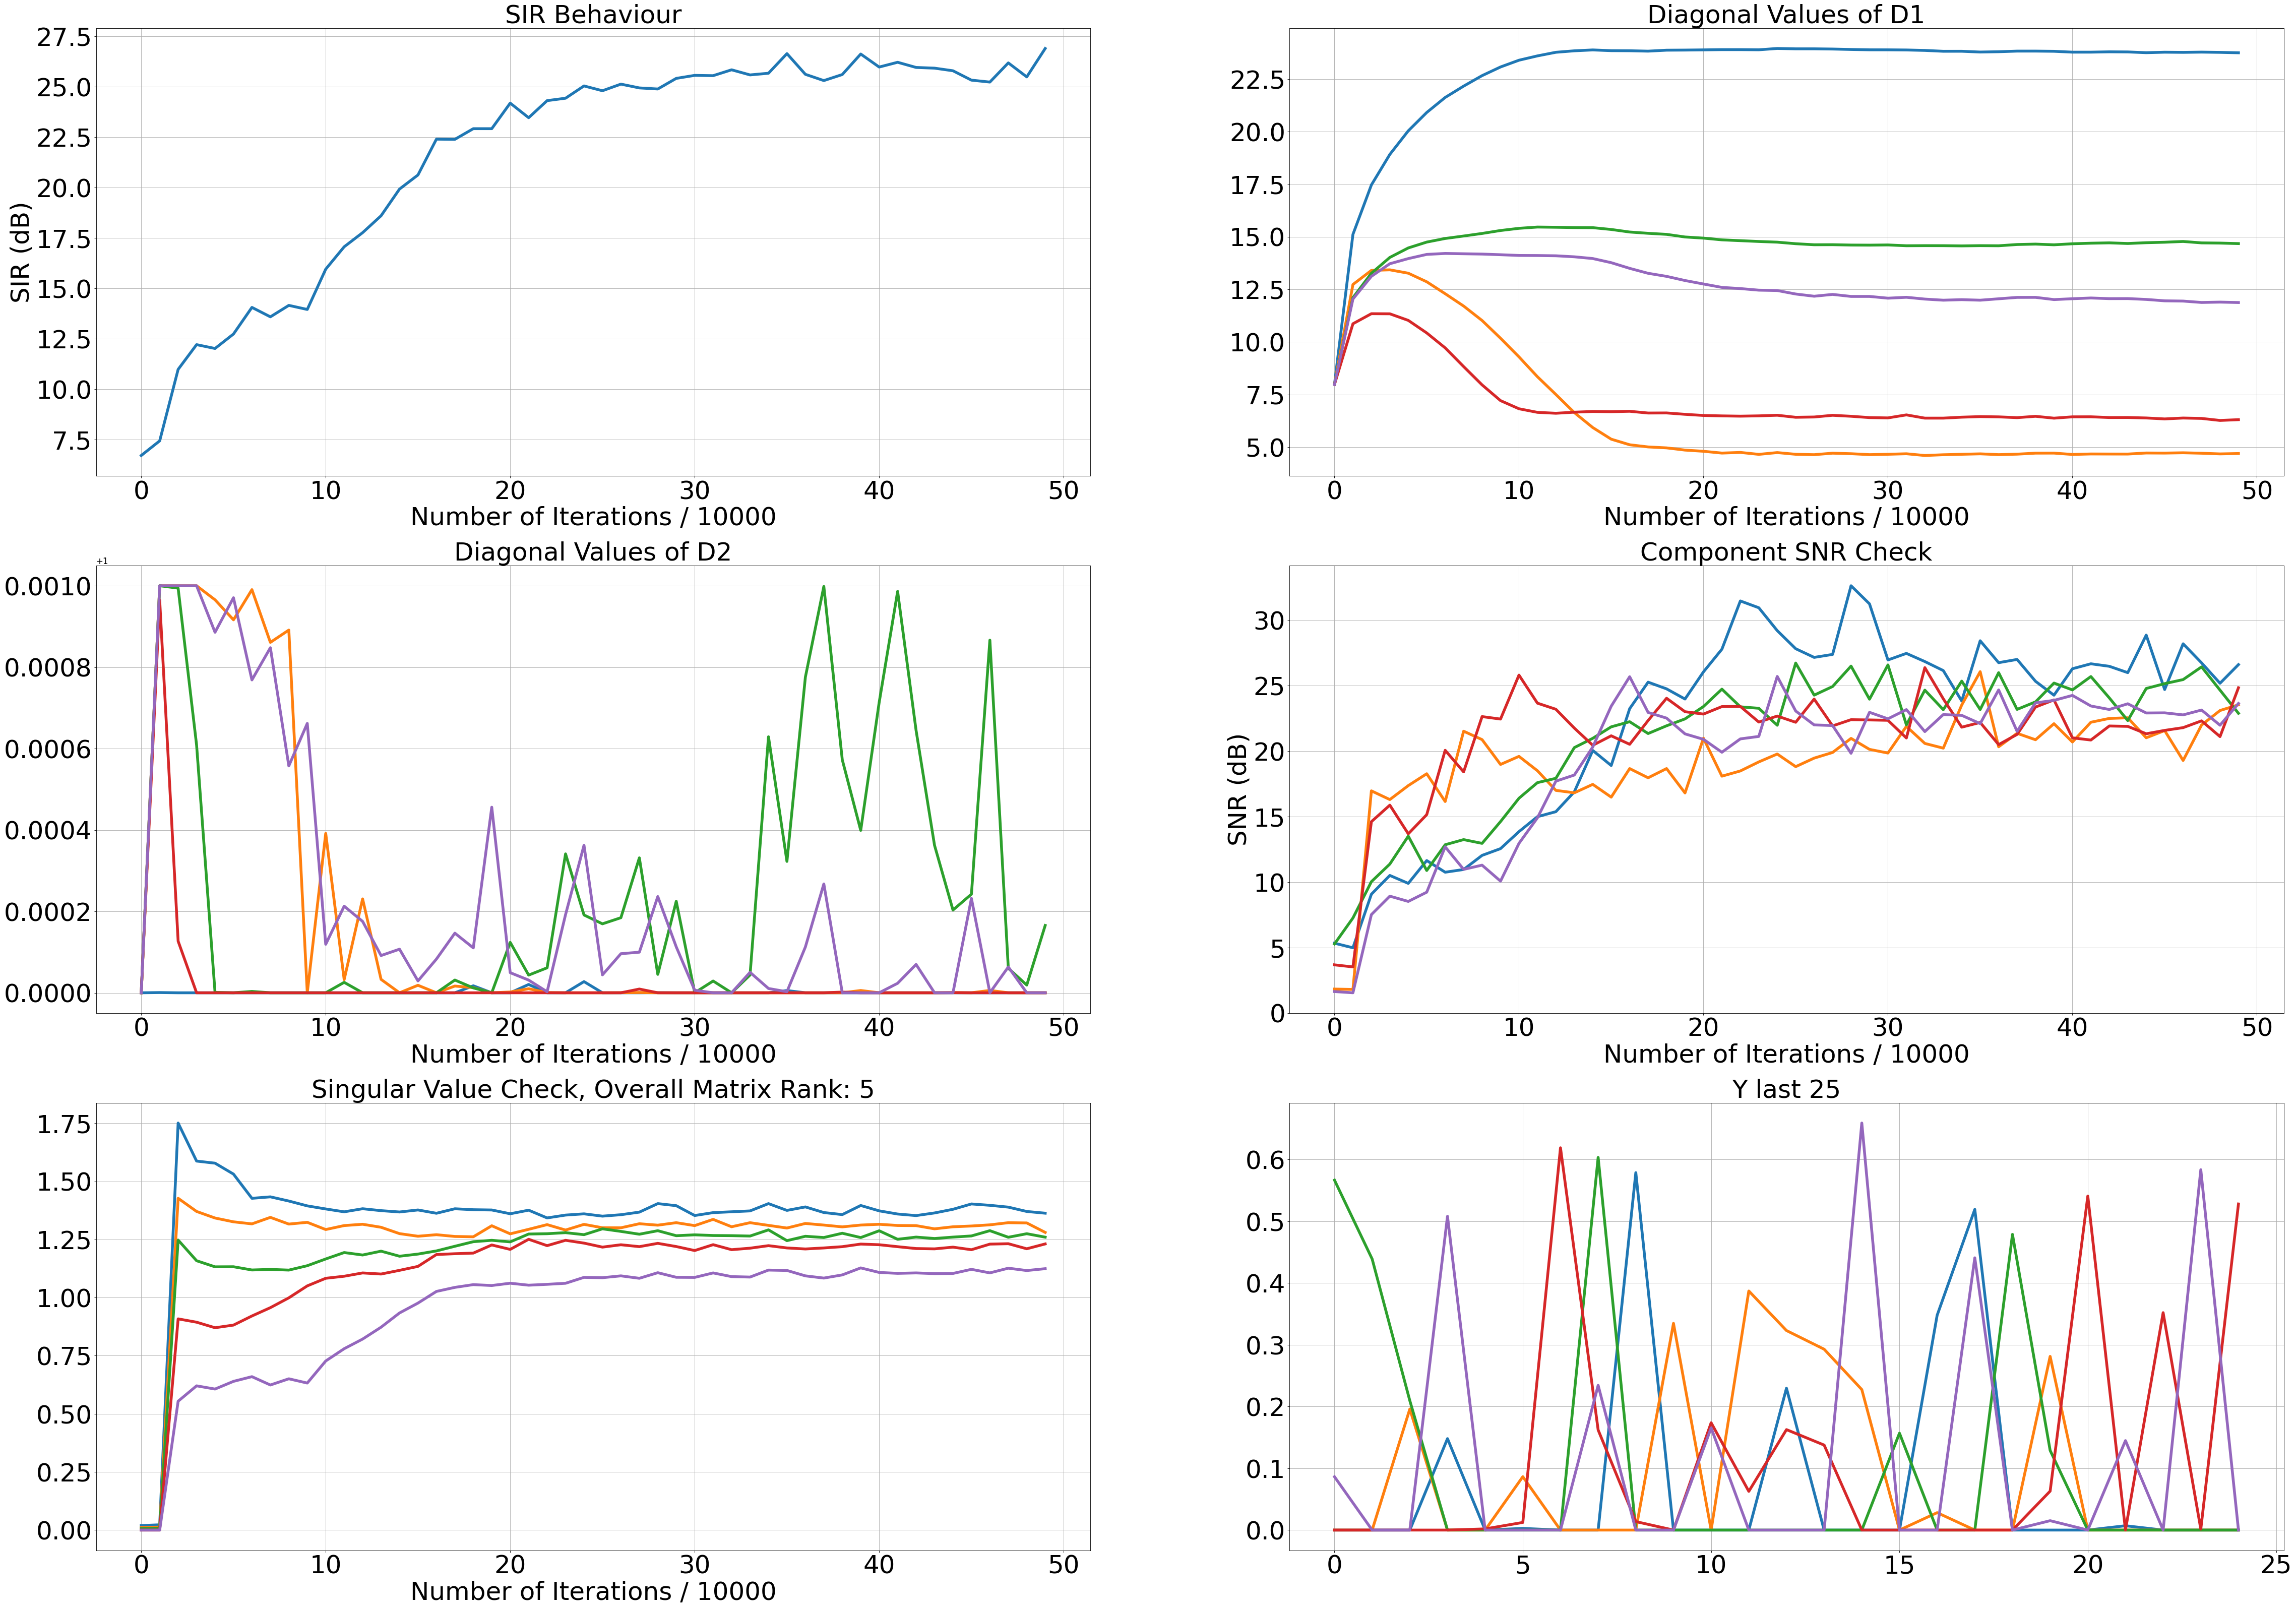

100%|██████████| 500000/500000 [07:08<00:00, 1168.19it/s]


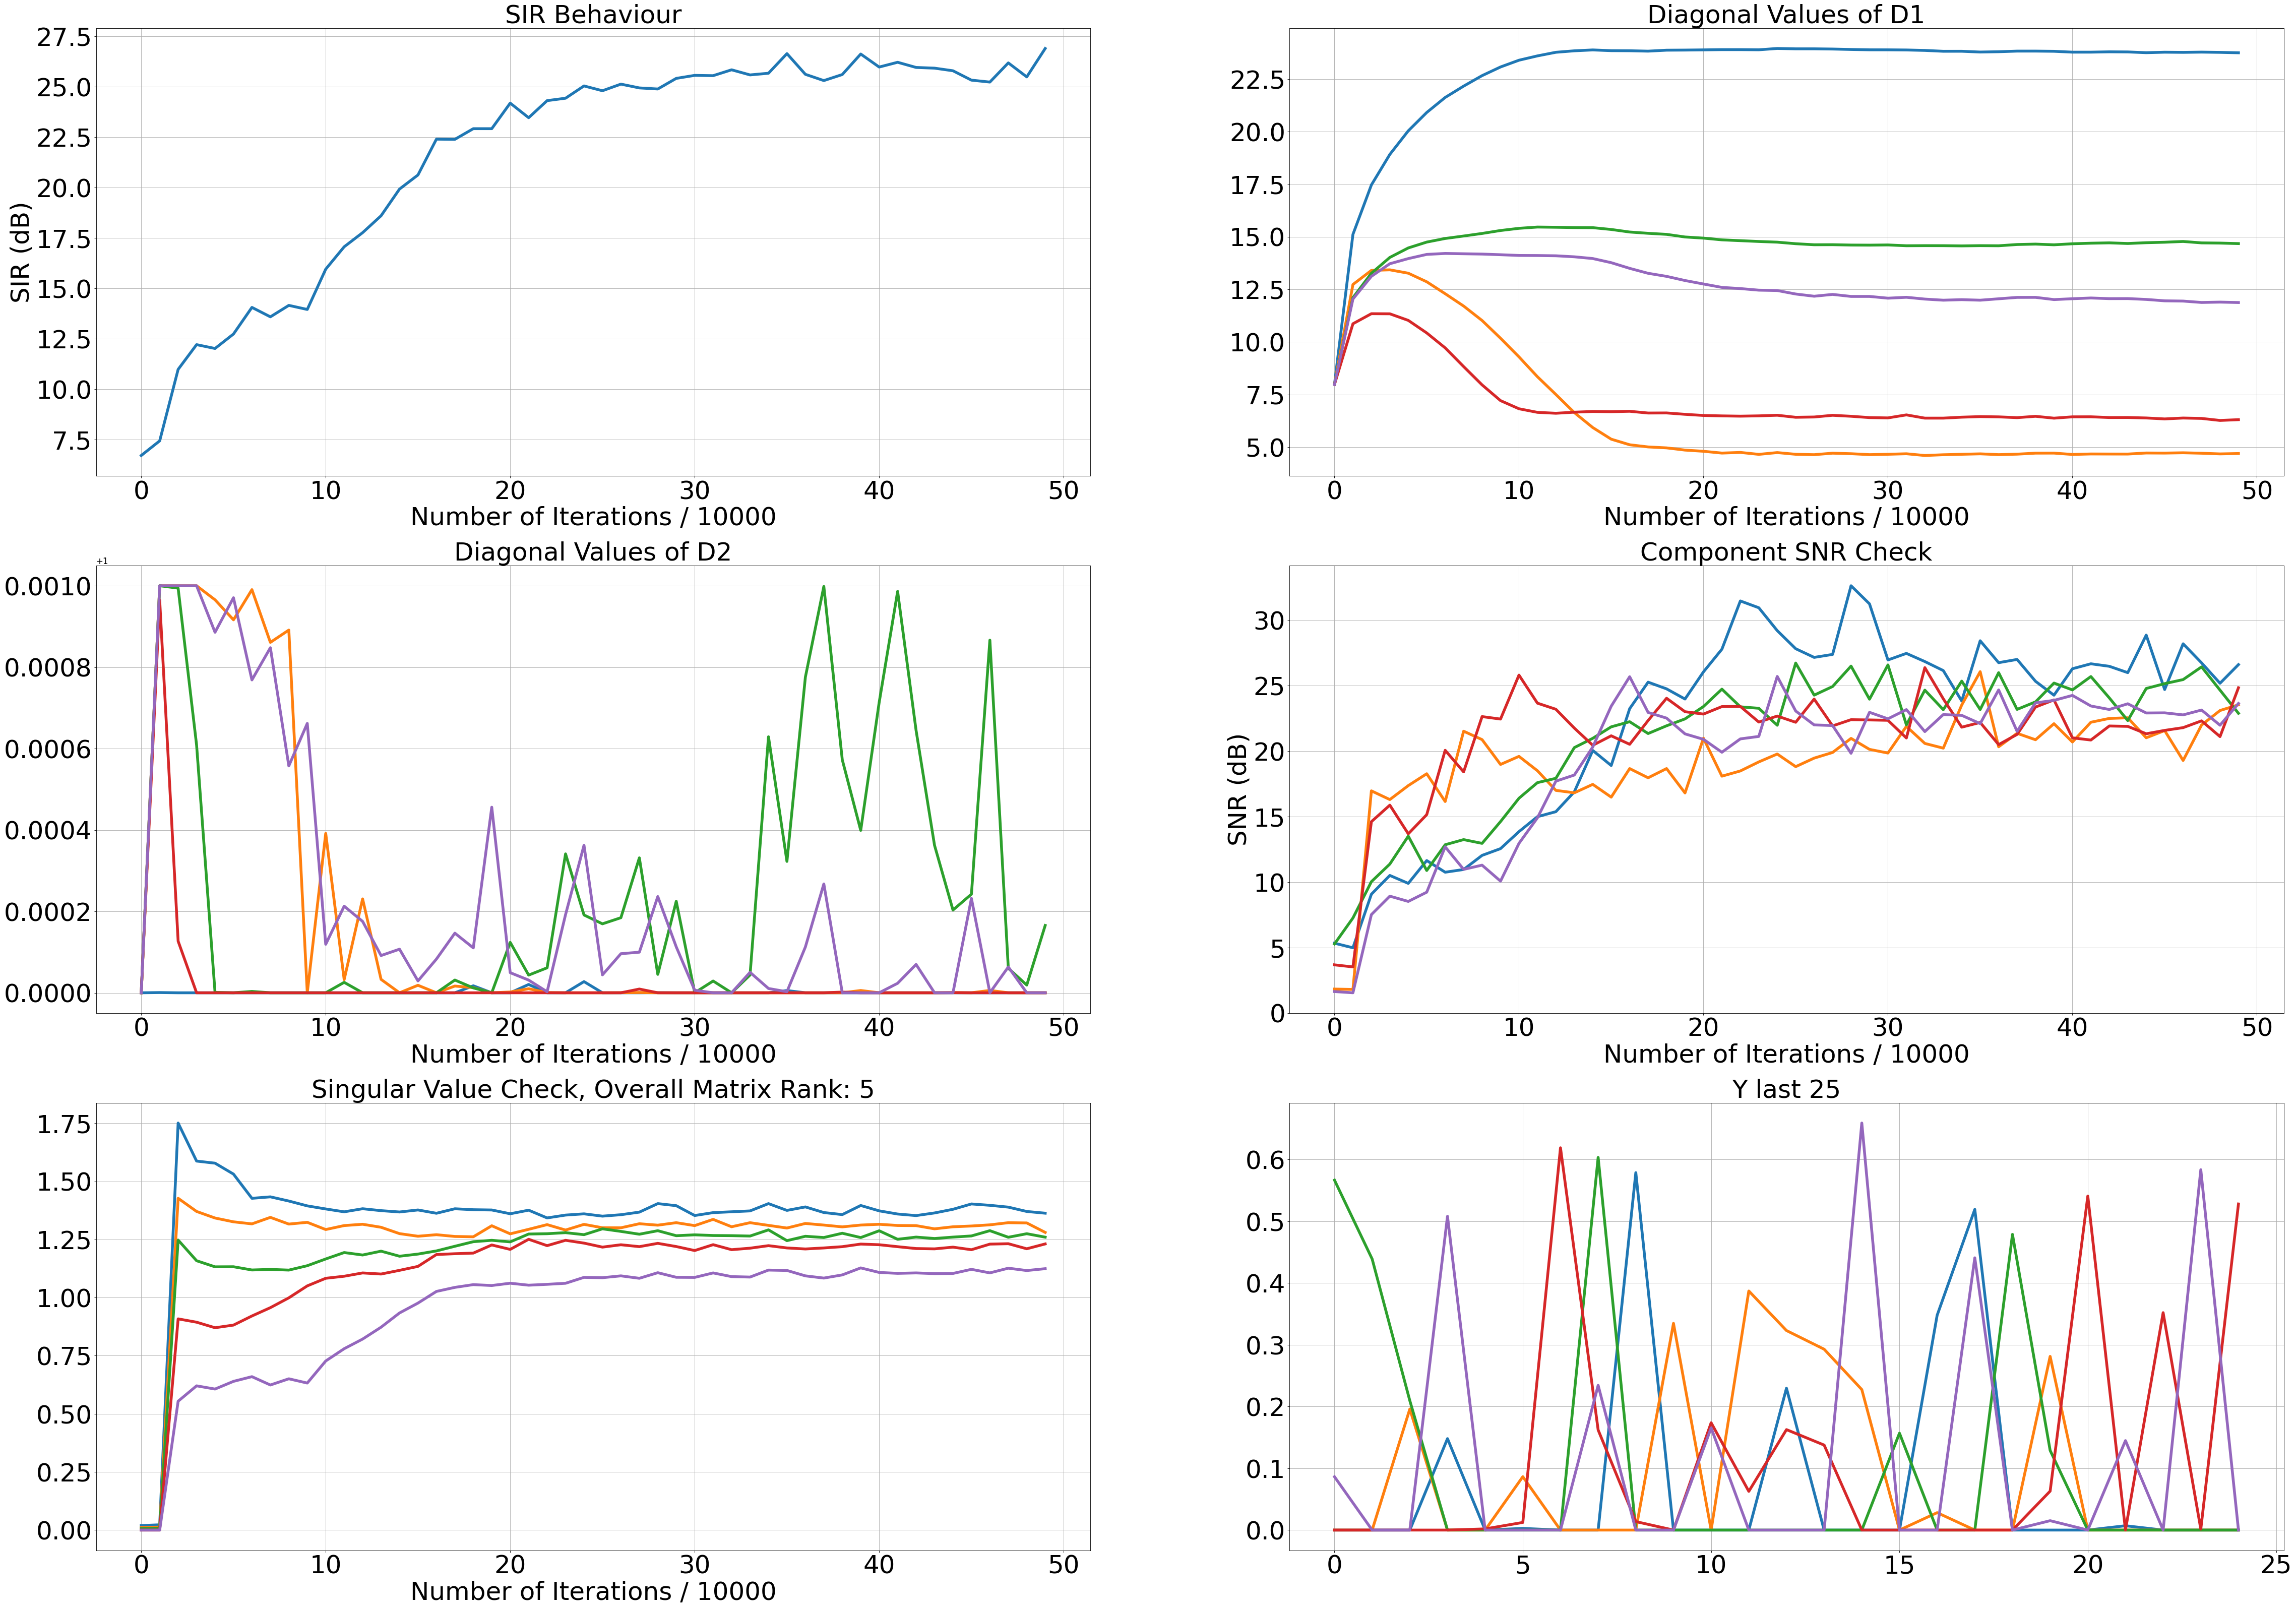

In [6]:
debug_iteration_point = 10000

model = OnlineWSMBSS(s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                     gamma_start = MUS, beta = beta, zeta = zeta, 
                     muD = muD,WScalings = WScalings,
                     DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                     LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                     set_ground_truth = True, S = S, A = A)

model.fit_batch_nnsparse(X, n_epochs = 1, neural_lr_start = 0.3, 
                       debug_iteration_point = debug_iteration_point, 
                       plot_in_jupyter = True)

# Visualize SNR Convergence of Each Source Component

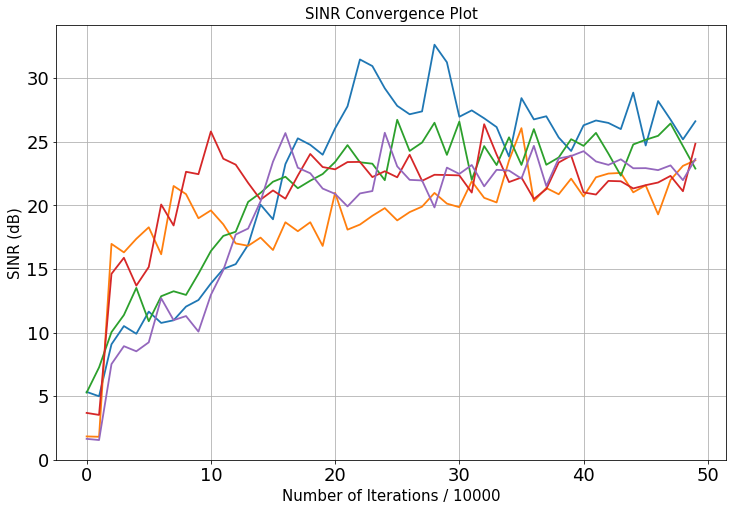

In [7]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [8]:
Wf = model.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr(S.T, Y_)))

SINRwsm = 10*np.log10(CalculateSINR(Y_.T, S)[0])

print("Overall SINR : {}".format(SINRwsm))

Component SNR Values : [22.87743611 21.8169097  27.01163359 21.82305553 22.73036683]

Overall SINR : 25.631539817303928


# Vizualize Extracted Signals Compared to Original Sources

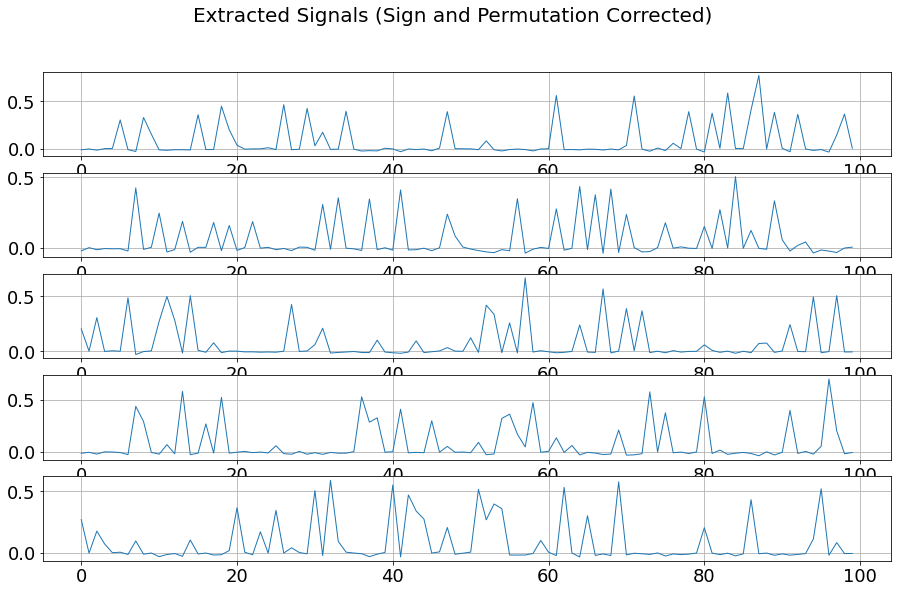

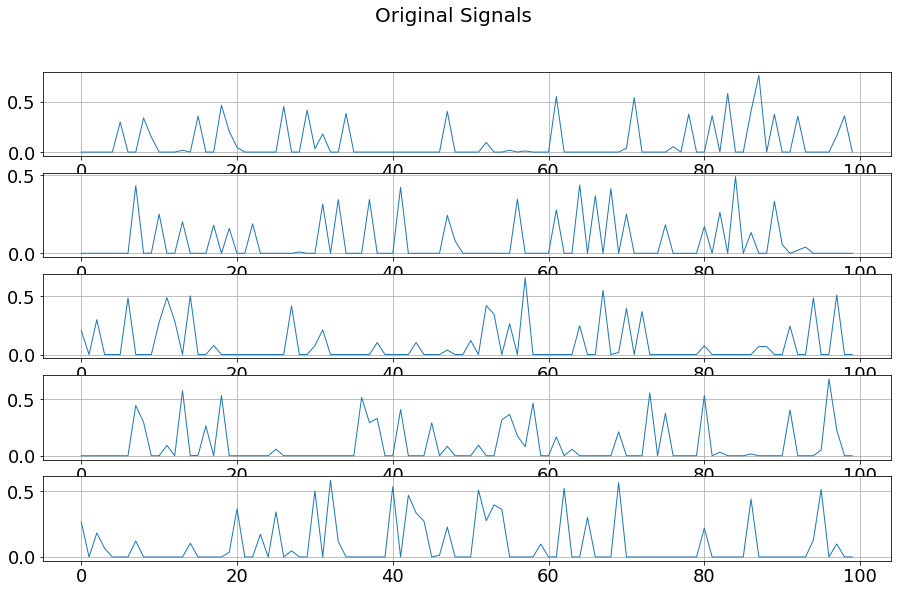

In [9]:
subplot_1D_signals(Y_[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)

In [10]:
import mir_eval

In [11]:
S.shape, Y_.T.shape

((5, 500000), (5, 500000))

In [15]:
mir_eval.separation.bss_eval_sources(S, Y_.T,
                     compute_permutation=True)

(array([25.58152917, 24.55826069, 29.05479942, 24.91483503, 25.18294057]),
 array([26.40818343, 25.38008128, 31.26017973, 25.3709066 , 26.25570101]),
 array([33.20282512, 32.20533067, 33.05718266, 34.94097969, 31.79137405]),
 array([0, 1, 2, 3, 4]))